# Hands-on 01: Modelagem da cobertura celula com sombreamento

## Entregas Parte 02: Modelagem da cobertura celula com sombreamento

### Entrega 03: Comprovação do fator de ajuste do desvio padrão do sombreamento correlacionado

Escreva um código para comprovar que o desvio padrão das amostras do sombreamento correlacionado tem o mesmo desvio padrão de entrada **dSigmaShad**. Comprovar que isso é verdade independente do valor de **dAlphaCorr**.

Verificar se as amostras **mtShadowingCorr** tem sombreamento com desvio padrão **dSigmaShad** para alguns valores de **dAlphaCorr**.

Desvio-padrão da ERB 0: 8.10841502363784
Desvio-padrão da ERB 1: 8.3597762787072
Desvio-padrão da ERB 2: 7.604308385454325
Desvio-padrão da ERB 3: 8.161928443228671
Desvio-padrão da ERB 4: 7.558495584342593
Desvio-padrão da ERB 5: 7.81062220749648
Desvio-padrão da ERB 6: 7.485665251393298
Desvio-padrão médio obtido: 7.869887310608631


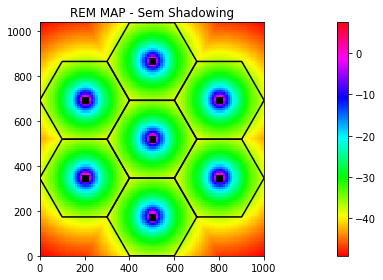

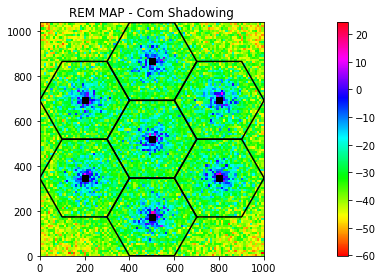

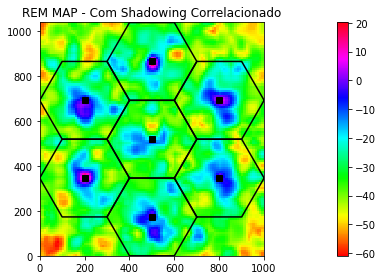

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import cmath
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib
from random import randint   
import itertools 
from fCorrShadowing import fCorrShadowing 

def fDrawSector (dR, dCenter):
    vtHex=np.zeros([1,0])
    for ie in range(1,7):
        vtHex = np.append(vtHex, dR*complex(np.cos((ie-1)*np.pi/3), np.sin((ie-1)*np.pi/3)))
    vtHex = vtHex+dCenter
    vtHexp = np.append(vtHex, vtHex[0])
    #print(vtHex)
    plt.plot(vtHexp.real,vtHexp.imag, 'k')
    #plt.grid()
    #plt.tight_layout()
    #plt.show()
    
def fDrawDeploy(dR, vtBs):
    for iBsd in range(len(vtBs)):
        fDrawSector(dR, vtBs[iBsd])
    plt.plot(vtBs.real,vtBs.imag, 'sk')
    plt.axis('scaled')
    #plt.grid()
    plt.tight_layout()
    #plt.show()
    

# Entrada de parâmetros
dR = 200; #Raio do Hexágono
dFc = 800;
dShad = 50;
dSigmaShad = 8;
dAlphaCorr = 0.5;

dPasso = 10;
dRmin = dPasso;
dIntersiteDistance = 2*np.sqrt(3/4)*dR;

dDimXOri = 5*dR;
dDimYOri = 6*np.sqrt(3/4)*dR;
dPtdBm = 57;
dPtLinear = 10**(dPtdBm/10)*(1e-3);
dHMob = 5;
dHBs = 30;
dAhm = 3.2*(np.log10(11.75*dHMob))**2 - 4.97;

vtBs= [0];
dOffset = np.pi/6;
for iBs in range(2,8):
    vtBs = np.append(vtBs, dR*np.sqrt(3)*np.exp(complex(0,(iBs-2)*np.pi/3 + dOffset)));
vtBs = vtBs + complex(dDimXOri/2,dDimYOri/2);

dDimY = dDimYOri + np.mod(dDimYOri, dPasso);
dDimX = dDimXOri + np.mod(dDimXOri, dPasso);
[mtPosx, mtPosy] = np.meshgrid(np.arange(0,dDimXOri+1,dPasso), np.arange(0,dDimYOri+1,dPasso));
mtPontosMedicao = mtPosx + 1j*mtPosy; 

mtPosEachBS = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)], dtype=complex);
mtPowerEachBSdBm = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)]);
mtPowerEachBSShaddBm = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)]);
mtPowerEachBSShadCorrdBm = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)]);
mtPowerFinaldBm = -np.inf*np.ones([mtPosy.shape[0],mtPosy.shape[1]]);
mtPowerFinalShaddBm = -np.inf*np.ones([mtPosy.shape[0],mtPosy.shape[1]]);
mtPowerFinalShadCorrdBm = -np.inf*np.ones([mtPosy.shape[0],mtPosy.shape[1]]);

for x in range(mtPosx.shape[0]):
    for y in range (mtPosx.shape[1]):
        mtPosEachBS[x,y,:] = complex(mtPosx[x,y],mtPosy[x,y]);
        
mtShadowingCorr = fCorrShadowing(mtPontosMedicao, dShad, dAlphaCorr, dSigmaShad, dDimXOri, dDimYOri);
meanstd = [];
for z in range(0,7):
    stdproof = np.std(mtShadowingCorr[:,:, z]);
    meanstd = np.append(meanstd, stdproof);
    print('Desvio-padrão da ERB ' + str(z) + ': ' + str(stdproof));
meanstdproof = np.mean(meanstd);
# if meanstdproof < dSigmaShad:
#     meanstdproof = np.ceil(meanstdproof);
# elif meanstdproof > dSigmaShad:
#     meanstdproof = np.floor(meanstdproof);
print('Desvio-padrão médio obtido: ' + str(meanstdproof));
                       
for iBsD in range(len(vtBs)):
    mtPosEachBS[:,:,iBsD] = mtPosEachBS[:,:,iBsD]-vtBs[iBsD];
    mtDistEachBS = np.abs(mtPosEachBS[:,:,iBsD]);
    mtDistEachBS[mtDistEachBS < dRmin] = dRmin;
    # Okumura-Hata (cidade urbana) - dB
    mtPldB = 69.55 + 26.16*np.log10(dFc) + (44.9 - 6.55*np.log10(dHBs))*np.log10(mtDistEachBS/1e3) - 13.82*np.log10(dHBs) - dAhm;
    
    mtShadowing = dSigmaShad*np.random.randn(mtPosy.shape[0], mtPosy.shape[1]);
    
    mtPowerEachBSdBm[:,:,iBsD] = dPtdBm - mtPldB;
    
    mtPowerEachBSShaddBm[:,:,iBsD] = dPtdBm - mtPldB + mtShadowing;
    
    mtPowerEachBSShadCorrdBm[:,:, iBsD] = dPtdBm - mtPldB + mtShadowingCorr[:,:,iBsD];
    mtPowerFinaldBm = np.maximum(mtPowerFinaldBm, mtPowerEachBSdBm[:,:,iBsD]);
    mtPowerFinalShaddBm = np.maximum(mtPowerFinalShaddBm, mtPowerEachBSShaddBm[:,:,iBsD]);
    mtPowerFinalShadCorrdBm = np.maximum(mtPowerFinalShadCorrdBm, mtPowerEachBSShadCorrdBm[:,:,iBsD]);

plt.pcolormesh(mtPosx,mtPosy,mtPowerFinaldBm, cmap='hsv');
plt.colorbar();
plt.title("REM MAP - Sem Shadowing");
fDrawDeploy(dR, vtBs);
plt.axis('scaled');
plt.tight_layout()

plt.figure();
plt.pcolormesh(mtPosx,mtPosy,mtPowerFinalShaddBm, cmap='hsv');
plt.colorbar();
plt.title("REM MAP - Com Shadowing");
fDrawDeploy(dR, vtBs);
plt.axis('scaled');
plt.tight_layout()

plt.figure();
plt.pcolormesh(mtPosx,mtPosy,mtPowerFinalShadCorrdBm, cmap='hsv');
plt.colorbar();
plt.title("REM MAP - Com Shadowing Correlacionado");
fDrawDeploy(dR, vtBs);
plt.axis('scaled');
plt.tight_layout()
plt.show();

### Entrega 04: Modelagem e avaliação da inclusão de microcélulas

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import cmath
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import sys
import argparse
import yaml
import matplotlib
import time
from random import randint   
import itertools  
    
def fDrawMicroCell (dR, dCenter):
    vtHex=np.zeros([1,0])
    for ie in range(1,7):
        vtHex = np.append(vtHex, dR*complex(np.cos((ie-1)*np.pi/3), np.sin((ie-1)*np.pi/3)))
    vtHex = vtHex+dCenter
    vtHexp = np.append(vtHex, vtHex[0])
    plt.plot(vtHexp.real,vtHexp.imag, 'k')

    
def fDrawDeployMicroCell(dR, vtBs):
    #for iBsd in range(len(vtBs)):
    #    fDrawSector(dR, vtBs[iBsd])
    plt.plot(vtBs.real,vtBs.imag, 'sg')
    plt.axis('scaled')
    plt.tight_layout()

def fDrawSector (dR, dCenter):
    vtHex=np.zeros([1,0])
    for ie in range(1,7):
        vtHex = np.append(vtHex, dR*complex(np.cos((ie-1)*np.pi/3), np.sin((ie-1)*np.pi/3)))
    vtHex = vtHex+dCenter
    vtHexp = np.append(vtHex, vtHex[0])
    plt.plot(vtHexp.real,vtHexp.imag, 'k')

    
def fDrawDeploy(dR, vtBs):
    for iBsd in range(len(vtBs)):
        fDrawSector(dR, vtBs[iBsd])
    plt.plot(vtBs.real,vtBs.imag, 'sk')
    plt.axis('scaled')
    plt.tight_layout()
    
def fDeployMacroOutage(dFc, dR):        
    dPasso = np.ceil(dR/100);
    dRMin = dPasso;
    dIntersiteDistance = 2*np.sqrt(3/4)*dR;
    dDimX = 5*dR;
    dDimY = 6*np.sqrt(3/4)*dR;
    dPtdBm = 21;
    dPtLinear = 10**(dPtdBm/10)*1e-3;
    dSensitivity = -90;
    dHMob = 1.5;
    dHBs = 32;
    dAhm = 3.2*(np.log10(11.75*dHMob))**(2) - 4.97; # Fator de correção
    
    vtBs = [0];
    dOffset = np.pi/6;
    for iBs in range(2,8):
        vtBs = np.append(vtBs, dR*np.sqrt(3)*np.exp(complex(0,(iBs-2)*np.pi/3 + dOffset)));
    vtBs = vtBs + complex(dDimX/2,dDimY/2);
    
    dDimY = np.ceil(dDimY + np.mod(dDimY, dPasso));
    dDimX = np.ceil(dDimX + np.mod(dDimX, dPasso));
    
    [mtPosx, mtPosy] = np.meshgrid(np.arange(0,dDimX+1,dPasso), np.arange(0,dDimY+1,dPasso));
    
    
    mtPosEachBS = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)], dtype=complex);
    mtPowerEachBSdBm = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)]);
    mtPowerFinaldBm = -np.inf*np.ones([mtPosy.shape[0],mtPosy.shape[1]]);
    
    for x in range(mtPosx.shape[0]):
        for y in range (mtPosx.shape[1]):
            mtPosEachBS[x,y,:] = complex(mtPosx[x,y],mtPosy[x,y]);
        
        
    for iBsD in range(len(vtBs)):
        mtPosEachBS[:,:,iBsD] = mtPosEachBS[:,:,iBsD]-vtBs[iBsD];
        mtDistEachBS = np.abs(mtPosEachBS[:,:,iBsD]);
        mtDistEachBS[mtDistEachBS < dRMin] = dRMin;
        mtPldB = 69.55 + 26.16*np.log10(dFc) + (44.9 - 6.55*np.log10(dHBs))*np.log10(mtDistEachBS/1e3) - 13.82*np.log10(dHBs) - dAhm;
        mtPowerEachBSdBm[:,:,iBsD] = dPtdBm - mtPldB;
        mtPowerFinaldBm = np.maximum(mtPowerFinaldBm, mtPowerEachBSdBm[:,:,iBsD]);
        
    belowsensitivity = mtPowerFinaldBm[mtPowerFinaldBm < dSensitivity];
    allelements = mtPowerFinaldBm.flatten();
    mtPowerFinaldBm[mtPowerFinaldBm <= -90] = -90;
    mtPowerFinaldBm[mtPowerFinaldBm > -90] = 90;
    dOutRate = 100*len(belowsensitivity)/len(allelements);
    fig = plt.figure();
    plt.pcolormesh(mtPosx,mtPosy,mtPowerFinaldBm, cmap='jet_r');
    plt.colorbar();
    fDrawDeploy(dR, vtBs);
    plt.axis('scaled');
    plt.title("7 MacroCells");
    print("Frequência: " + str(dFc) + " MHz");
    print("Raio da célula: " + str(dR/1000) + " km");
    print("Outage: " + str(dOutRate) + " %");
    print("-------------------------------------------");
    return dOutRate;
    
def fDeployMicroOutage(dFc, dR, dFcM, vtBsMC):
        
    dPasso = np.ceil(dR/100);
    dPtMBSdBm = 20;
    dRMin = dPasso;
    dIntersiteDistance = 2*np.sqrt(3/4)*dR;
    dDimX = 5*dR;
    dDimY = 6*np.sqrt(3/4)*dR;
    dPtdBm = 21;
    dPtLinear = 10**(dPtdBm/10)*1e-3;
    dSensitivity = -90;
    dHMob = 1.5;
    dHBs = 32;
    dAhm = 3.2*(np.log10(11.75*dHMob))**(2) - 4.97; # Fator de correção
    
    vtBs = [0];
    dOffset = np.pi/6;
    for iBs in range(2,8):
        vtBs = np.append(vtBs, dR*np.sqrt(3)*np.exp(complex(0,(iBs-2)*np.pi/3 + dOffset)));
    vtBs = vtBs + complex(dDimX/2,dDimY/2);
    
    dDimY = np.ceil(dDimY + np.mod(dDimY, dPasso));
    dDimX = np.ceil(dDimX + np.mod(dDimX, dPasso));
    
    [mtPosx, mtPosy] = np.meshgrid(np.arange(0,dDimX+1,dPasso), np.arange(0,dDimY+1,dPasso));
    
    
    mtPosEachBS = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)], dtype=complex);
    mtPosEachMBS = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBsMC)], dtype=complex);
    mtPowerEachBSdBm = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)]);
    mtPowerEachMBSdBm = np.empty([mtPosx.shape[0],mtPosx.shape[1],len(vtBs)]);
    mtPowerFinaldBm = -np.inf*np.ones([mtPosy.shape[0],mtPosy.shape[1]]);
    
    for x in range(mtPosx.shape[0]):
        for y in range (mtPosx.shape[1]):
            mtPosEachBS[x,y,:] = complex(mtPosx[x,y],mtPosy[x,y]);
            mtPosEachMBS[x,y,:] = complex(mtPosx[x,y],mtPosy[x,y]);
        
        
    for iBsD in range(len(vtBs)):
        mtPosEachBS[:,:,iBsD] = mtPosEachBS[:,:,iBsD]-vtBs[iBsD];
        mtDistEachBS = np.abs(mtPosEachBS[:,:,iBsD]);
        mtDistEachBS[mtDistEachBS < dRMin] = dRMin;
        mtPldB = 69.55 + 26.16*np.log10(dFc) + (44.9 - 6.55*np.log10(dHBs))*np.log10(mtDistEachBS/1e3) - 13.82*np.log10(dHBs) - dAhm;
        mtPowerEachBSdBm[:,:,iBsD] = dPtdBm - mtPldB;
        mtPowerFinaldBm = np.maximum(mtPowerFinaldBm, mtPowerEachBSdBm[:,:,iBsD]);
    for iBsDM in range(len(vtBsMC)):
        mtPosEachMBS[:,:,iBsDM] = mtPosEachMBS[:,:,iBsDM]-vtBsMC[iBsDM];
        mtDistEachMBS = np.abs(mtPosEachMBS[:,:,iBsDM]);
        mtDistEachMBS[mtDistEachMBS < dRMin] = dRMin;
        mtPlMBSdB = 55 + 38 * np.log10(mtDistEachMBS/1e3) + (24.5 + (1.5*dFcM)/925)*np.log10(dFcM);
        mtPowerEachMBSdBm[:,:,iBsDM] = dPtMBSdBm - mtPlMBSdB;
        mtPowerFinaldBm = np.maximum(mtPowerFinaldBm, mtPowerEachMBSdBm[:,:,iBsDM]);
        
    belowsensitivity = mtPowerFinaldBm[mtPowerFinaldBm < dSensitivity];
    allelements = mtPowerFinaldBm.flatten();
    mtPowerFinaldBm[mtPowerFinaldBm <= -90] = -90;
    mtPowerFinaldBm[mtPowerFinaldBm > -90] = 90;
    dOutRate = 100*len(belowsensitivity)/len(allelements);
    plt.pcolormesh(mtPosx,mtPosy,mtPowerFinaldBm, cmap='jet_r');
    plt.colorbar();
    fDrawDeploy(dR, vtBs);
    fDrawDeployMicroCell(dR/2, vtBsMC);
    plt.axis('scaled');
    plt.title("7 MacroCells + 6 MicroCells");
    print("Frequência Macrocélula: " + str(dFc) + " MHz");
    print("Frequência Microcélula: " + str(dFcM) + " MHz");
    print("Outage: " + str(dOutRate) + " %");
    print("-------------------------------------------");
    return dOutRate;

Frequência: 800 MHz
Raio da célula: 0.5 km
Outage: 44.26885193145379 %
-------------------------------------------
Frequência Macrocélula: 800 MHz
Frequência Microcélula: 800 MHz
Outage: 38.03448764658782 %
-------------------------------------------


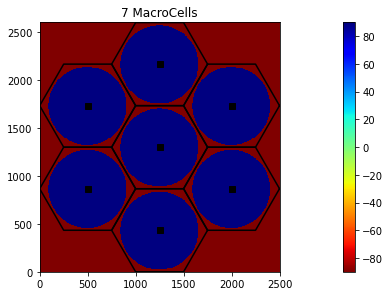

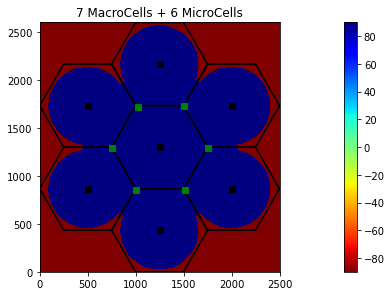

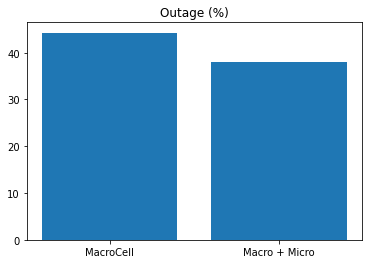

In [3]:
outage1 = fDeployMacroOutage(800, 500);
plt.figure();
vtBsMC = np.array([1007+1j*849, 1514+1j*856, 1758+1j*1294, 1507+1j*1727, 1020+1j*1715, 751+1j*1288], dtype = complex);
outage2 = fDeployMicroOutage(800, 500, 800, vtBsMC);
plt.figure();
plt.title('Outage (%)');
plt.bar(['MacroCell', 'Macro + Micro'], [outage1, outage2]);

Frequência: 1800 MHz
Raio da célula: 0.5 km
Outage: 83.3936733059792 %
-------------------------------------------
Frequência Macrocélula: 1800 MHz
Frequência Microcélula: 1800 MHz
Outage: 78.83656870519997 %
-------------------------------------------


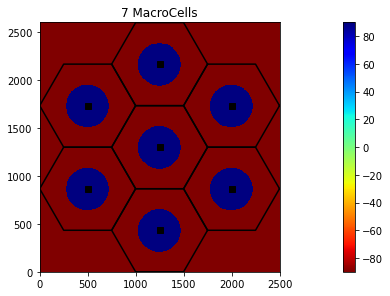

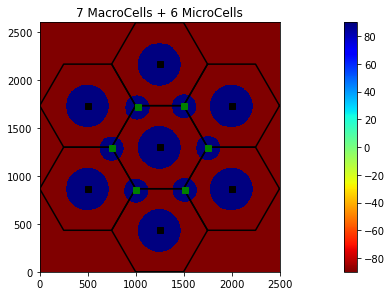

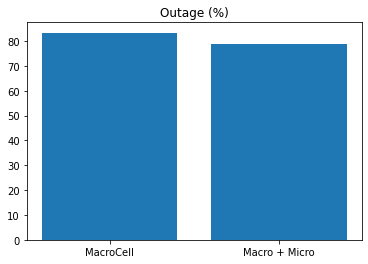

In [4]:
outage1 = fDeployMacroOutage(1800, 500);
plt.figure();
vtBsMC = np.array([1007+1j*849, 1514+1j*856, 1758+1j*1294, 1507+1j*1727, 1020+1j*1715, 751+1j*1288], dtype = complex);
outage2 = fDeployMicroOutage(1800, 500, 1800, vtBsMC);
plt.figure();
plt.title('Outage (%)');
plt.bar(['MacroCell', 'Macro + Micro'], [outage1, outage2]);

Frequência: 2100 MHz
Raio da célula: 0.5 km
Outage: 86.80450998195548 %
-------------------------------------------
Frequência Macrocélula: 2100 MHz
Frequência Microcélula: 2100 MHz
Outage: 83.81432911528191 %
-------------------------------------------


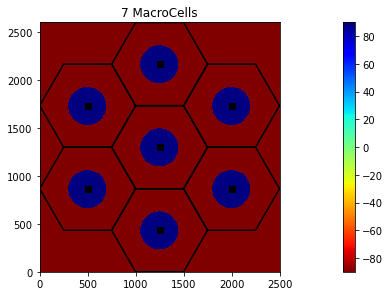

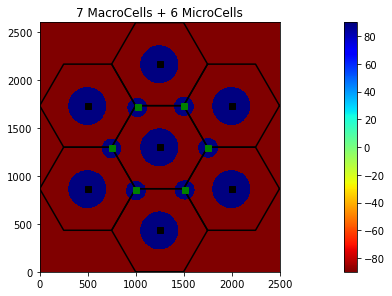

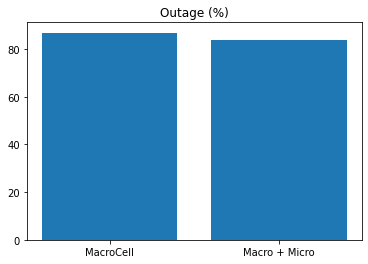

In [5]:
outage1 = fDeployMacroOutage(2100, 500);
plt.figure();
vtBsMC = np.array([1007+1j*849, 1514+1j*856, 1758+1j*1294, 1507+1j*1727, 1020+1j*1715, 751+1j*1288], dtype = complex);
outage2 = fDeployMicroOutage(2100, 500, 2100, vtBsMC);
plt.figure();
plt.title('Outage (%)');
plt.bar(['MacroCell', 'Macro + Micro'], [outage1, outage2]);